# **Hand Identification System that identifies people from RGB hand images**

## **Before you start**

**Move to the directory of the notebook - only for Google Colab**

In [ ]:
cd /content/drive/MyDrive/Colab Notebooks/rgb_hand

/content/drive/MyDrive/Colab Notebooks/rgb_hand


**Load Libraries**

In [ ]:
import pandas as pd
import cv2
import numpy as np
from cv2.ximgproc import guidedFilter
import mediapipe as mp

from keras import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.metrics import classification_report

**Load the CSV file**

In [ ]:
ds = pd.read_csv("dorsal_right_30_comb.csv")

**Split train and test datasets**

In [ ]:
# Create a dictionary to store the count of images for each ID
id_counts = {}

# Iterate through the DataFrame to count the number of images for each ID
for idx, row in ds.iterrows():
    id_num = row["ID"]
    if id_num in id_counts:
        id_counts[id_num] += 1
    else:
        id_counts[id_num] = 1

# Create a list to store the indices of the test data
test_indices = []

# Iterate through the DataFrame to find the last 2 images for each ID
for idx, row in ds.iterrows():
    id_num = row["ID"]
    if id_counts[id_num] > 2:
        id_counts[id_num] -= 1
    else:
        test_indices.append(idx)

# Split the DataFrame into training and testing datasets
train_ds = ds.drop(test_indices)
test_ds = ds.iloc[test_indices]

## **Pre-Processing**

**Remove Background from Hand Image**

In [ ]:
def remove_background(img_path):    
  mp_selfie_segmentation = mp.solutions.selfie_segmentation
  selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=1)

  # Read image
  image = cv2.imread(img_path)

  # Resize to 244x244
  image = cv2.resize(image, (224, 224))

  # Convert image from BGR to RGB
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  # Get the segmentation mask
  results = selfie_segmentation.process(image)

  # Extract the segmentation mask
  mask = results.segmentation_mask

  # Create a binary mask where foreground is white and the background is black
  mask = np.stack((mask,)*3, axis=-1)
  mask = np.where(mask > 0.1, 255, 0).astype('uint8')

  # Invert the mask
  mask_inv = cv2.bitwise_not(mask)

  # Create a white background image of the same size as the original image
  background = np.ones_like(image)*255

  # Apply the mask to the original image to get foreground
  foreground = cv2.bitwise_and(image, mask)

  # Apply the inverted mask to the white background to get background
  background = cv2.bitwise_and(background, mask_inv)

  # Combine the foreground and background to get the final result
  result = cv2.add(foreground, background)

  return result

**High Detailed BGR Pre-Processing**

In [ ]:
def high_bgr(img_path):

  # Normalise the image
  norm = np.array(img_path, dtype=np.float32) / 255.0
  
  # Apply the guided filter to get a smoothed - low frequency image
  low_img = guidedFilter(norm, norm, 10, 0.05)

  # Convert the image to BGR
  bgr = cv2.cvtColor(low_img, cv2.COLOR_RGB2BGR)

  # Divide normalised image to low frequency image
  high_bgr = np.uint8(cv2.normalize(np.divide(cv2.cvtColor(norm, cv2.COLOR_RGB2BGR), bgr), None, 0, 255, cv2.NORM_MINMAX))

  return high_bgr

**Function that applies background removal and high detail image conversion**

In [ ]:
def preprocess_image(img_path):

  # Remove the background
  image = remove_background(img_path)

  # Get high detailed image
  output_img = high_bgr(image) # Change this to apply different pre-processing

  return output_img

**Prepare the train and test data**

In [ ]:
# Prepare the train data
train_data = []
for i, row in train_ds.iterrows():
    img_path = "/content/drive/MyDrive/Colab Notebooks/rgb_hand/hands_comb/" + row["ImageName"]
    output_img = preprocess_image(img_path)
    train_data.append(output_img)

train_data = np.array(train_data)
train_labels = train_ds["ID"].values

# Prepare test data
test_data = []
for i, row in test_ds.iterrows():
    img_path = "/content/drive/MyDrive/Colab Notebooks/rgb_hand/hands_comb/" + row["ImageName"]
    output_img = preprocess_image(img_path)
    test_data.append(output_img)

test_data = np.array(test_data)
test_labels = test_ds["ID"].values

## **Feature extraction and Training**

**Split the train data into training and validation sets**

In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

**Model architecture**

In [ ]:
# Load the VGG16 model
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))

# Freeze the layers
for layer in vgg_model.layers:
    layer.trainable = False

# Add the fully connected layers
model = Sequential()
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(30, activation='softmax'))

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr=0.00001), metrics=['accuracy'])

# Display the model structure
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 4096)              102764544 
                                                                 
 dense_1 (Dense)             (None, 30)                122910    
                                                                 
Total params: 117,602,142
Trainable params: 102,887,454
Non-trainable params: 14,714,688
_________________________________________________________________


**Train model and save it**

In [ ]:
model_tr = model.fit(train_data, train_labels, epochs=25, batch_size=12, shuffle=True, validation_data=(val_data, val_labels))

model.save('trained_model.h5')

Epoch 1/25
15/15 [==============================] - 6s 112ms/step - loss: 214.3158 - accuracy: 0.3389 - val_loss: 95.1121 - val_accuracy: 0.6500
Epoch 2/25
15/15 [==============================] - 1s 91ms/step - loss: 26.5355 - accuracy: 0.7944 - val_loss: 25.9139 - val_accuracy: 0.7333
Epoch 3/25
15/15 [==============================] - 1s 90ms/step - loss: 5.9778 - accuracy: 0.9556 - val_loss: 17.9059 - val_accuracy: 0.8167
Epoch 4/25
15/15 [==============================] - 1s 90ms/step - loss: 1.3852 - accuracy: 0.9889 - val_loss: 18.5049 - val_accuracy: 0.8167
Epoch 5/25
15/15 [==============================] - 1s 87ms/step - loss: 0.6897 - accuracy: 0.9889 - val_loss: 13.6361 - val_accuracy: 0.8833
Epoch 6/25
15/15 [==============================] - 1s 90ms/step - loss: 0.1680 - accuracy: 0.9944 - val_loss: 12.3573 - val_accuracy: 0.8833
Epoch 7/25
15/15 [==============================] - 1s 87ms/step - loss: 1.0267 - accuracy: 0.9889 - val_loss: 12.5091 - val_accuracy: 0.8833
Ep

**Plot learning curves**

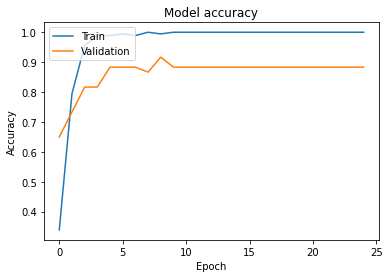

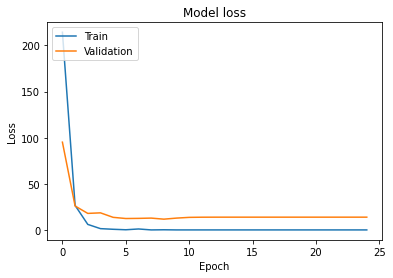

In [ ]:
# Plot accuracy
plt.plot(model_tr.history['accuracy'])
plt.plot(model_tr.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss
plt.plot(model_tr.history['loss'])
plt.plot(model_tr.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## **Evaluation and Testing**

**Evaluation Metrics**

In [ ]:
# Predict the labels for test data
predictions = model.predict(test_data)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate loss
test_loss, test_accu = model.evaluate(test_data, test_labels) 
print('Accuracy:', test_accu)
print('Loss:', test_loss)

# Calculate precision, recall, and F1-score for each class
target_names = [f"ID_{i}" for i in range(30)]
report = classification_report(test_labels, predicted_labels, target_names=target_names)
print(report)

2/2 [==============================] - 1s 142ms/step - loss: 28.5314 - accuracy: 0.8167
Accuracy: 0.8166666626930237
Loss: 28.531368255615234
              precision    recall  f1-score   support

        ID_0       1.00      1.00      1.00         2
        ID_1       1.00      1.00      1.00         2
        ID_2       1.00      1.00      1.00         2
        ID_3       1.00      0.50      0.67         2
        ID_4       1.00      1.00      1.00         2
        ID_5       1.00      1.00      1.00         2
        ID_6       0.00      0.00      0.00         2
        ID_7       0.40      1.00      0.57         2
        ID_8       0.50      0.50      0.50         2
        ID_9       1.00      1.00      1.00         2
       ID_10       0.67      1.00      0.80         2
       ID_11       1.00      1.00      1.00         2
       ID_12       1.00      1.00      1.00         2
       ID_13       1.00      0.50      0.67         2
       ID_14       1.00      1.00      1.00    

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Testing**

*Correctly Predicted from "11k hands"*

1/1 [==============================] - 1s 805ms/step
Input image ID: 0
Predicted label: 0


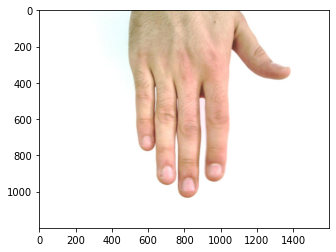

In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model('trained_model.h5')

# Input image path
img_path = "/content/drive/MyDrive/Colab Notebooks/rgb_hand/hands_comb/Hand_0000010.jpg"

# Input image ID
img_ID = 0

# Preprocess the input image
output_img = preprocess_image(img_path)

# Expand dimension from (224,224,3) to (1, 224, 224, 3) for the prediction
input_image = np.expand_dims(output_img, axis=0)

# Pass the preprocessed image through the loaded model
prediction = loaded_model.predict(input_image)


# Extract the predicted class with the highest probability
predicted_class = np.argmax(prediction)


# Show the input image with its ID and the predicted ID
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
print('Input image ID:', img_ID)
print('Predicted label:', predicted_class)

*Correctly Predicted from "HKPU"*

1/1 [==============================] - 0s 172ms/step
Input image ID: 1
Predicted label: 1


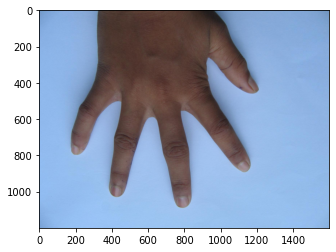

In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model('trained_model.h5')

# Input image path
img_path = "/content/drive/MyDrive/Colab Notebooks/rgb_hand/hands_comb/195_IMG_4688.jpg"

# Input image ID
img_ID = 1

# Preprocess the input image
output_img = preprocess_image(img_path)

# Expand dimension from (224,224,3) to (1, 224, 224, 3) for the prediction
input_image = np.expand_dims(output_img, axis=0)

# Pass the preprocessed image through the loaded model
prediction = loaded_model.predict(input_image)


# Extract the predicted class with the highest probability
predicted_class = np.argmax(prediction)


# Show the input image with its ID and the predicted ID
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
print('Input image ID:', img_ID)
print('Predicted label:', predicted_class)

*Incorrect Prediction*

1/1 [==============================] - 0s 459ms/step
Input image ID: 3
Predicted label: 16


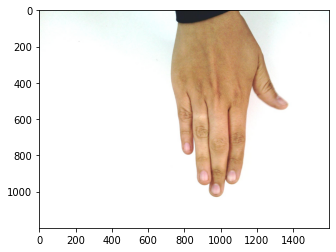

In [ ]:
# Load the saved model
loaded_model = tf.keras.models.load_model('trained_model.h5')

# Input image path
img_path = "/content/drive/MyDrive/Colab Notebooks/rgb_hand/hands_comb/Hand_0000717.jpg"

# Input image ID
img_ID = 3

# Preprocess the input image
output_img = preprocess_image(img_path)

# Expand dimension from (224,224,3) to (1, 224, 224, 3) for the prediction
input_image = np.expand_dims(output_img, axis=0)

# Pass the preprocessed image through the loaded model
prediction = loaded_model.predict(input_image)


# Extract the predicted class with the highest probability
predicted_class = np.argmax(prediction)


# Show the input image with its ID and the predicted ID
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
print('Input image ID:', img_ID)
print('Predicted label:', predicted_class)

*Hand Image with ID 16*

Input image ID: 16


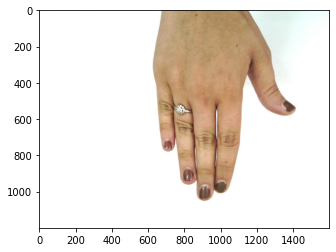

In [ ]:
# Input image path
img_path = "/content/drive/MyDrive/Colab Notebooks/rgb_hand/hands_comb/Hand_0001099.jpg"

# Input image ID
img_ID = 16

# Show the input image with its ID and the predicted ID
plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
print('Input image ID:', img_ID)